# Yugipedia data analysis

## Preamble

### Imports

In [609]:
import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from datetime import datetime
from ast import literal_eval

### Lists for query

In [562]:
# Attributes to split monsters query
attributes = ['DIVINE', 'LIGHT', 'DARK', 'WATER', 'EARTH', 'FIRE', 'WIND']
# API variables
api_url = 'https://yugipedia.com/api.php'
monster_search = '|?English%20name=Name|?Password|?Card%20type|?Primary%20type|?Secondary%20type|?Attribute|?Type=Monster%20type|?Stars%20string=Level%2FRank%20|?ATK%20string=ATK|?DEF%20string=DEF|?Pendulum%20Scale|?Link%20Rating=Link|?Link%20Arrows|?Effect%20type|?TCG%20status|?OCG%20status|?Modification%20date|limit%3D5000'
st_search = '|?English%20name=Name|?Password|?Card%20type|?Property|?Effect%20type|?TCG%20status|?OCG%20status|?Modification%20date|limit%3D5000'
# Styling dictionaries
arrows_dict = {'Middle-Left': '\u2190', 'Middle-Right': '\u2192', 'Top-Left': '\u2196', 'Top-Center': '\u2191', 'Top-Right': '\u2197', 'Bottom-Left': '\u2199', 'Bottom-Center': '\u2193', 'Bottom-Right': '\u2198'}
card_colors = {'Effect Monster': '#FF8B53', 'Normal Monster': '#FDE68A', 'Ritual Monster': '#9DB5CC', 'Fusion Monster': '#A086B7', 'Synchro Monster': '#CCCCCC', 'Xyz Monster': '#000000', 'Link Monster': '#00008B', 'Pendulum Monster': 'r', 'Monster Card': '#FF8B53', 'Spell Card': '#1D9E74', 'Trap Card': '#BC5A84', 'Monster Token': '#C0C0C0', 'FIRE': '#fd1b1b', 'WATER': '#03a9e6', 'EARTH': '#060d0a', 'WIND': '#77bb58', 'DARK': '#745ea5', 'LIGHT': '#9d8047', 'DIVINE': '#7e6537', 'Level': '#f1a41f'}

### Formatting functions

In [567]:
def extract_results(df):
    df = pd.DataFrame(df['query']['results']).transpose()
    df = pd.DataFrame(df['printouts'].values.tolist())
    return df

In [568]:
def format_df(input_df):
    df = pd.DataFrame()
    df['Name'] = input_df['Name'].dropna().apply(lambda x: x[0])
    df['Password'] = input_df['Password'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'Card type' in input_df.columns:
        df['Card type'] = input_df['Card type'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Property' in input_df.columns:
        df['Property'] = input_df['Property'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'Primary type' in input_df.columns:
        df['Primary type'] = input_df['Primary type'].dropna().apply(lambda x: [i['fulltext'] for i in x] if len(x)>0 else []).apply(lambda y: list(filter(lambda z: z != 'Pendulum Monster', y)) if len(y)>0 else []).apply(lambda y: list(filter(lambda z: z != 'Effect Monster', y))[0] if len(y)>1 else (y[0] if len(y)>0 else np.nan))
    if 'Secondary type' in input_df.columns:
        df['Secondary type'] = input_df['Secondary type'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Attribute' in input_df.columns:
        df['Attribute'] = input_df['Attribute'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Monster type' in input_df.columns:
        df['Monster type'] = input_df['Monster type'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Level/Rank' in input_df.columns:
        df['Level/Rank'] = input_df['Level/Rank'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'ATK' in input_df.columns:
        df['ATK'] = input_df['ATK'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'DEF' in input_df.columns:
        df['DEF'] = input_df['DEF'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'Pendulum Scale' in input_df.columns:
        df['Pendulum Scale'] = input_df['Pendulum Scale'].dropna().apply(lambda x: str(x[0]) if len(x)>0 else np.nan)
    if 'Link' in input_df.columns:
        df['Link'] = input_df['Link'].dropna().apply(lambda x: str(x[0]) if len(x)>0 else np.nan)
    if 'Link Arrows' in input_df.columns:
        df['Link Arrows'] = input_df['Link Arrows'].dropna().apply(lambda x: tuple([arrows_dict[i] for i in sorted(x)]) if len(x)>0 else np.nan)
    if 'Effect type' in input_df.columns:
        df['Effect type'] = input_df['Effect type'].dropna().apply(lambda x: tuple(sorted([i['fulltext'] for i in x])) if len(x)>0 else np.nan)
    df['TCG status'] = input_df['TCG status'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    df['OCG status'] = input_df['OCG status'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    df['Modification date'] = input_df['Modification date'].dropna().apply(lambda x: pd.Timestamp(int(x[0]['timestamp']), unit='s').ctime() if len(x)>0 else np.nan)
    return df

### API call functions

In [569]:
def fetch_spell():
    print('Downloading Spells')
    spell_df = pd.read_json(f'{api_url}?action=ask&query=[[Concept:CG%20Spell%20Cards]]{st_search}|order%3Dasc&format=json')
    spell_df = extract_results(spell_df)
    print(f'{len(spell_df.index)} results\n')
    return spell_df

def fetch_trap():
    print('Downloading Traps')
    trap_df = pd.read_json(f'{api_url}?action=ask&query=[[Concept:CG%20Trap%20Cards]]{st_search}|order%3Dasc&format=json')
    trap_df = extract_results(trap_df)
    print(f'{len(trap_df.index)} results\n')
    return trap_df

def fetch_monster():
    print('Downloading Monsters')
    monster_df = pd.DataFrame()
    for i in attributes:
        print(f"- {i}")
        df = pd.read_json(f'{api_url}?action=ask&query=[[Concept:CG%20monsters]][[Attribute::{i}]]{monster_search}|order%3Dasc&format=json')
        df = extract_results(df)
        print(f'{len(df.index)} results')
        monster_df = pd.concat([monster_df, df], ignore_index=True, axis=0)
        
    print(f'- Total\n{len(monster_df.index)} results')
    return monster_df

## Data aquisition

### Fetch online data

In [566]:
# Timestamp
timestamp = pd.Timestamp.now().timestamp()
full_df = pd.DataFrame()

# Fetch Spell
spell_df = fetch_spell()
full_df = pd.concat([full_df, spell_df], ignore_index=True, axis=0)

# Fetch Trap
trap_df = fetch_trap()
full_df = pd.concat([full_df, trap_df], ignore_index=True, axis=0)
st_df = pd.concat([spell_df, trap_df], ignore_index=True, axis=0)

# Fetch Monster
monster_df = fetch_monster()
full_df = pd.concat([full_df, monster_df], ignore_index=True, axis=0)

2311 results

1776 results

- DIVINE
9 results
- LIGHT
1599 results
- DARK
2179 results
- WATER
815 results
- EARTH
1845 results
- FIRE
647 results
- WIND
755 results
- Total
7849 results


### Format data

In [570]:
formatted_spell_df = format_df(spell_df)
formatted_trap_df = format_df(trap_df)
formatted_st_df = format_df(st_df)
formatted_monster_df = format_df(monster_df)
formatted_full_df = format_df(full_df)

### Save data

In [571]:
formatted_full_df.to_csv(f'cards_{timestamp}.csv', index = False)

## Check changes

### Load latest file

In [963]:
list_of_files = glob.glob('cards_*.csv')
latest_file = max(list_of_files, key=os.path.getctime)
previous_df = pd.read_csv(latest_file, dtype=object)

### Correct tuples

In [964]:
previous_df['Effect type'] = previous_df['Effect type'].dropna().apply(literal_eval)
previous_df['Link Arrows'] = previous_df['Link Arrows'].dropna().apply(literal_eval)

### Generate changelog

In [965]:
changelog = previous_df.merge(formatted_full_df,indicator = True, how='outer').loc[lambda x : x['_merge']!='both'].sort_values('Name', ignore_index=True)
changelog['_merge'].replace(['left_only','right_only'],['Old', 'New'], inplace = True)
changelog.rename(columns={"_merge": "Version"}, inplace = True)
nunique = changelog.groupby('Name').nunique()
cols_to_drop = nunique[nunique < 2].dropna(axis=1).columns
changelog = changelog.set_index('Name')[nunique > 1]
changelog.drop(cols_to_drop, axis=1, inplace = True)

In [966]:
changelog

""
Name


## Data visualisation

### Full data

In [578]:
formatted_full_df

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,TCG status,OCG status,Modification date
0,"""A"" Cell Breeding Device",34541863,Spell Card,Continuous Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Trigger Effect,)",Unlimited,Unlimited,Sat Nov 6 13:57:15 2021
1,"""A"" Cell Incubator",64163367,Spell Card,Continuous Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Continuous-like Effect, Trigger Effect)",Unlimited,Unlimited,Mon Jun 13 04:27:51 2022
2,"""A"" Cell Recombination Device",91231901,Spell Card,Quick-Play Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Effect, Ignition-like Effect)",Unlimited,Unlimited,Thu Mar 12 22:40:14 2020
3,"""A"" Cell Scatter Burst",73262676,Spell Card,Quick-Play Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Effect,)",Unlimited,Unlimited,Sat Nov 6 13:58:32 2021
4,"""Infernoble Arms - Durendal""",37478723,Spell Card,Equip Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Condition, Ignition-like Effect, Trigger Effect)",Unlimited,Unlimited,Sat Nov 27 20:48:13 2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11931,Yosenju Shinchu L,65025250,Monster Card,NaN,Effect Monster,NaN,WIND,Rock,4,0,2100,3,NaN,NaN,"(Continuous Effect, Continuous-like Effect, Tr...",Unlimited,Unlimited,Thu Nov 18 15:52:59 2021
11932,Yosenju Shinchu R,91420254,Monster Card,NaN,Effect Monster,NaN,WIND,Rock,4,0,2100,5,NaN,NaN,"(Continuous Effect, Ignition-like Effect, Trig...",Unlimited,Unlimited,Thu Nov 18 15:53:07 2021
11933,Yosenju Tsujik,25244515,Monster Card,NaN,Effect Monster,NaN,WIND,Beast-Warrior,4,1000,0,NaN,NaN,NaN,"(Condition, Ignition Effect, Quick Effect, Tri...",Unlimited,Unlimited,Sun Dec 20 18:15:02 2020
11934,ZW - Eagle Claw,29353756,Monster Card,NaN,Effect Monster,NaN,WIND,Winged Beast,5,2000,1200,NaN,NaN,NaN,"(Continuous-like Effect, Ignition Effect, Uncl...",Unlimited,Unlimited,Thu Jul 8 13:48:07 2021


### Card types

In [13]:
formatted_full_df.groupby('Card type').nunique()

,Name,Password,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,TCG status,OCG status,Modification date
Card type,,,,,,,,,,,,,,,,,
Monster Card,7841,7729,0,20,6,7,25,15,83,78,13,6,60,221,7,7,7783
Spell Card,2309,2287,6,0,0,0,0,0,0,0,0,0,0,112,5,6,2289
Trap Card,1776,1757,3,0,0,0,0,0,0,0,0,0,0,92,5,6,1766


<AxesSubplot:>

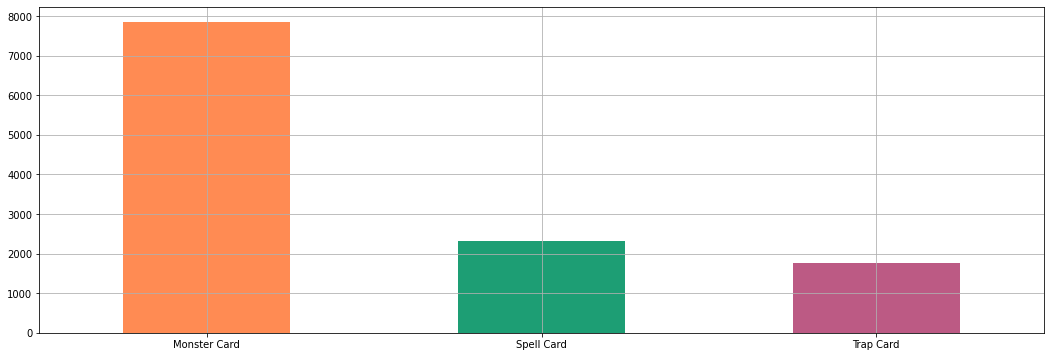

In [165]:
colors = [card_colors[i] for i in formatted_full_df['Card type'].value_counts().index]
formatted_full_df['Card type'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=0, color = colors)

### Monsters

#### Attributes

In [211]:
formatted_monster_df.drop(columns=['Card type']).groupby('Attribute').nunique()

,Name,Password,Primary type,Secondary type,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,TCG status,OCG status,Modification date
Attribute,,,,,,,,,,,,,,,
DARK,2176,2143,7,6,23,14,70,63,12,6,39,152,7,7,2170
DIVINE,6,0,1,0,2,2,3,3,0,0,0,6,2,2,7
EARTH,1843,1826,7,6,23,12,71,59,11,4,28,125,5,6,1839
FIRE,647,643,8,6,22,12,43,40,8,4,20,82,3,6,644
LIGHT,1599,1565,7,6,23,14,58,50,10,5,30,129,7,6,1590
WATER,815,806,7,6,22,11,56,41,9,4,16,90,7,7,814
WIND,755,746,7,6,23,12,47,39,11,4,14,103,6,6,750


<AxesSubplot:>

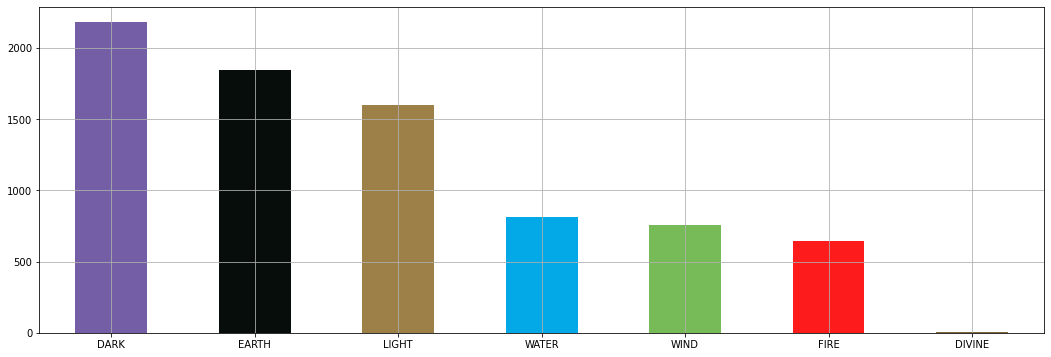

In [167]:
colors = [card_colors[i] for i in formatted_full_df['Attribute'].value_counts().index]
formatted_monster_df['Attribute'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=0, color = colors)

#### Primary types

In [212]:
formatted_monster_df.drop(columns=['Card type']).groupby('Primary type').nunique()

,Name,Password,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,TCG status,OCG status,Modification date
Primary type,,,,,,,,,,,,,,,
Effect Monster,5333,5284,6,7,25,12,74,67,13,0,0,203,6,6,5297
Fusion Monster,417,413,1,6,23,12,48,46,3,0,0,65,4,5,417
Link Monster,359,353,0,6,23,0,38,0,0,6,60,50,4,4,359
Monster Token,1,0,0,1,1,1,1,1,0,0,0,0,0,1,1
Normal Monster,743,700,1,6,23,10,59,49,10,0,0,6,4,4,744
Ritual Monster,115,115,2,6,15,12,33,26,1,0,0,31,2,1,115
Synchro Monster,400,395,1,6,23,13,40,38,4,0,0,55,5,6,399
Xyz Monster,477,469,0,6,23,14,51,42,4,0,0,66,4,6,474


##### Primary type vs. Attribute

In [538]:
pd.crosstab(formatted_full_df['Primary type'],formatted_full_df['Attribute'])

Attribute,DARK,DIVINE,EARTH,FIRE,LIGHT,WATER,WIND
Primary type,,,,,,,
Effect Monster,1468,6,1281,436,1081,539,522
Fusion Monster,141,0,79,34,96,34,33
Link Monster,116,0,73,31,86,28,25
Monster Token,0,0,0,1,0,0,0
Normal Monster,186,0,249,52,81,109,67
Ritual Monster,34,0,17,7,32,19,6
Synchro Monster,104,0,67,50,74,32,73
Xyz Monster,130,0,79,36,149,54,29


<AxesSubplot:xlabel='Attribute', ylabel='Primary type'>

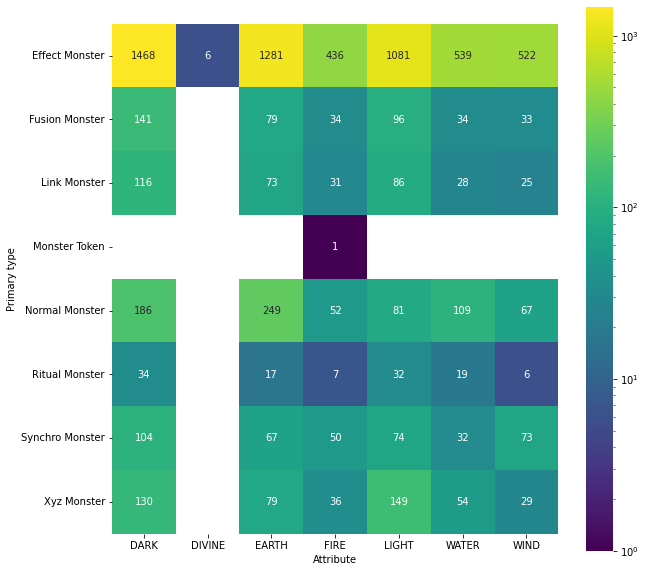

In [551]:
plt.figure(figsize = (10,10))
sns.heatmap(pd.crosstab(formatted_full_df['Primary type'],formatted_full_df['Attribute']), annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())

##### - Has effect discrimination

In [432]:
has_effect = formatted_monster_df['Primary type'].where(formatted_monster_df['Effect type'].notna()).value_counts().rename('Effect')
no_effect = formatted_monster_df['Primary type'].where(formatted_monster_df['Effect type'].isna()).value_counts().rename('No Effect')
effect = pd.concat([has_effect,no_effect], axis=1)
effect

,Effect,No Effect
Effect Monster,5332.0,1
Xyz Monster,475.0,2
Synchro Monster,397.0,3
Fusion Monster,355.0,62
Link Monster,354.0,5
Ritual Monster,99.0,16
Normal Monster,34.0,710
Monster Token,NaN,1


Normal monster can have effect if it is pendulum

<AxesSubplot:>

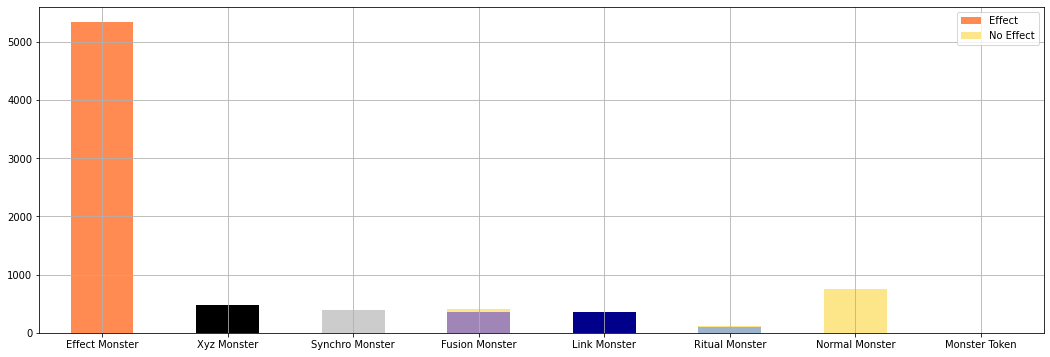

In [496]:
colors = {'No Effect': card_colors['Normal Monster'], 'Effect': [card_colors[i] for i in effect.index]}
effect.plot.bar(figsize = (18,6), stacked = True, grid = True, rot=0,  legend=True, color = colors)

##### - Is pendulum discrimination

In [371]:
not_pendulum = formatted_monster_df['Primary type'].where(formatted_monster_df['Pendulum Scale'].isna()).value_counts().rename('Not Pendulum')
is_pendulum = formatted_monster_df['Primary type'].where(formatted_monster_df['Pendulum Scale'].notna()).value_counts().rename('Pendulum')
pendulum = pd.concat([not_pendulum,is_pendulum], axis=1)
pendulum

,Not Pendulum,Pendulum
Effect Monster,5073,260.0
Normal Monster,706,38.0
Xyz Monster,470,7.0
Fusion Monster,408,9.0
Synchro Monster,395,5.0
Link Monster,359,NaN
Ritual Monster,114,1.0
Monster Token,1,NaN


<AxesSubplot:>

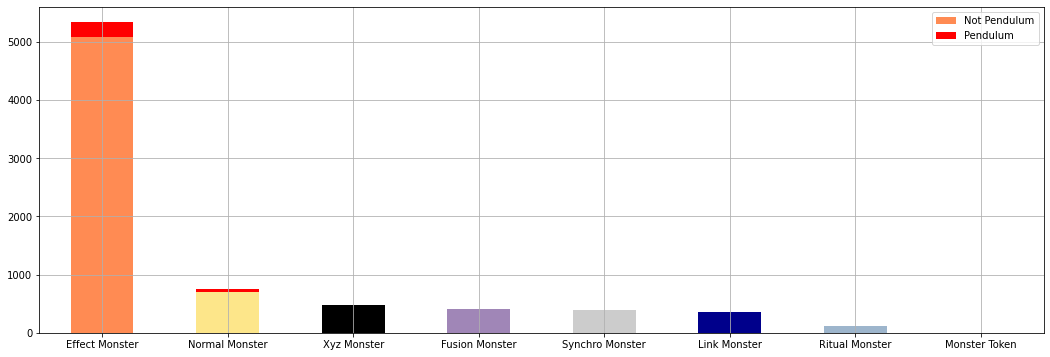

In [372]:
colors = {'Pendulum': card_colors['Pendulum Monster'], 'Not Pendulum': [card_colors[i] for i in pendulum.index]}
pendulum.plot.bar(figsize = (18,6), stacked = True, grid = True, rot=0, color = colors, legend=True)

#### Secondary types

In [217]:
formatted_monster_df.drop(columns=['Card type', 'Link', 'Link Arrows']).groupby('Secondary type').nunique()

,Name,Password,Primary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Effect type,TCG status,OCG status,Modification date
Secondary type,,,,,,,,,,,,,
Flip monster,180,179,1,6,19,12,38,33,1,18,3,5,180
Gemini monster,45,45,1,6,18,8,17,19,0,6,1,1,45
Spirit monster,36,36,2,6,13,9,22,20,2,7,2,2,36
Toon monster,17,17,1,6,7,5,12,15,0,8,1,2,17
Tuner monster,457,453,5,6,23,9,32,32,7,56,3,5,456
Union monster,37,37,1,6,9,8,17,14,0,6,1,1,37


<AxesSubplot:>

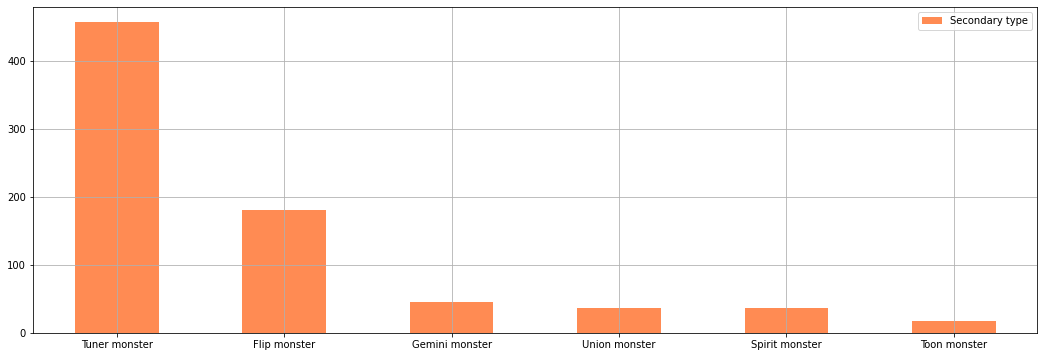

In [381]:
colors = card_colors['Effect Monster']
formatted_monster_df['Secondary type'].value_counts().plot.bar(figsize = (18,6), stacked = True, grid = True, rot=0, color = colors, legend=True)

##### Secondary type vs. Attribute

In [554]:
pd.crosstab(formatted_full_df['Secondary type'],formatted_full_df['Attribute'])

Attribute,DARK,EARTH,FIRE,LIGHT,WATER,WIND
Secondary type,,,,,,
Flip monster,50,60,9,31,13,17
Gemini monster,11,8,8,6,8,4
Spirit monster,5,6,6,4,6,9
Toon monster,7,5,1,2,1,1
Tuner monster,118,91,42,90,48,68
Union monster,6,9,3,12,4,3


<AxesSubplot:xlabel='Attribute', ylabel='Secondary type'>

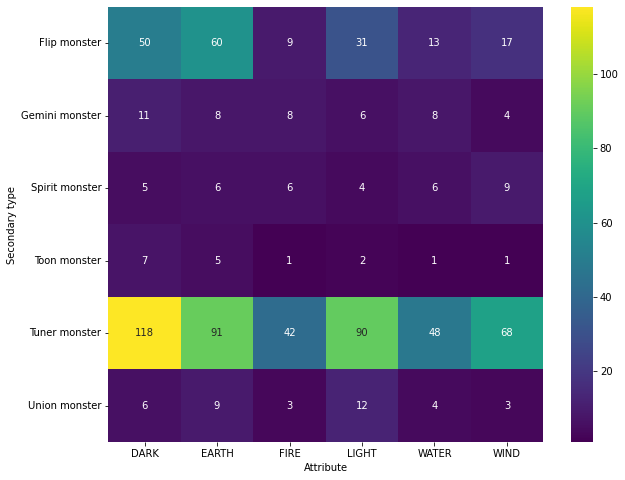

In [559]:
plt.figure(figsize = (10,8))
sns.heatmap(pd.crosstab(formatted_full_df['Secondary type'],formatted_full_df['Attribute']), annot=True, fmt="g", cmap='viridis', square=True)

##### Primary vs. Secondary type

In [501]:
pd.crosstab(formatted_full_df['Primary type'],formatted_full_df['Secondary type'], margins = True)

Secondary type,Flip monster,Gemini monster,Spirit monster,Toon monster,Tuner monster,Union monster,All
Primary type,,,,,,,
Effect Monster,180,45,34,17,412,37,725
Fusion Monster,0,0,0,0,3,0,3
Normal Monster,0,0,0,0,12,0,12
Ritual Monster,0,0,2,0,1,0,3
Synchro Monster,0,0,0,0,29,0,29
All,180,45,36,17,457,37,772


<AxesSubplot:xlabel='Secondary type', ylabel='Primary type'>

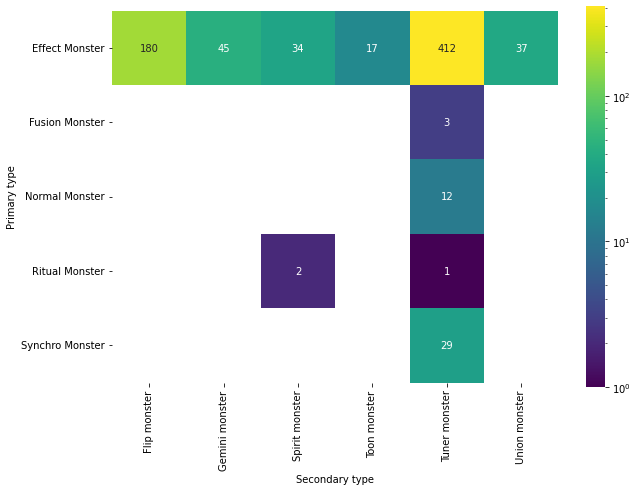

In [523]:
plt.figure(figsize = (10,7))
sns.heatmap(pd.crosstab(formatted_full_df['Primary type'],formatted_full_df['Secondary type']), annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())

#### Monster types

In [219]:
formatted_monster_df.drop(columns=['Card type']).groupby('Monster type').nunique()

,Name,Password,Primary type,Secondary type,Attribute,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,TCG status,OCG status,Modification date
Monster type,,,,,,,,,,,,,,,
Aqua,255,251,7,6,6,10,50,33,3,2,3,51,3,5,255
Beast,372,365,7,4,6,10,48,38,7,2,7,59,4,5,373
Beast-Warrior,234,230,7,3,6,10,36,29,6,3,6,58,4,5,233
Creator God,1,0,1,0,1,1,1,1,0,0,0,1,0,1,1
Cyberse,243,242,7,1,6,10,30,29,1,6,37,45,3,4,243
Dinosaur,120,119,6,1,6,10,34,30,4,2,3,35,3,3,120
Divine-Beast,5,0,1,0,1,1,3,3,0,0,0,5,2,2,6
Dragon,647,639,7,6,6,13,52,48,9,5,19,109,6,7,645
Fairy,495,485,7,5,6,12,43,38,8,4,12,76,7,5,491


<AxesSubplot:>

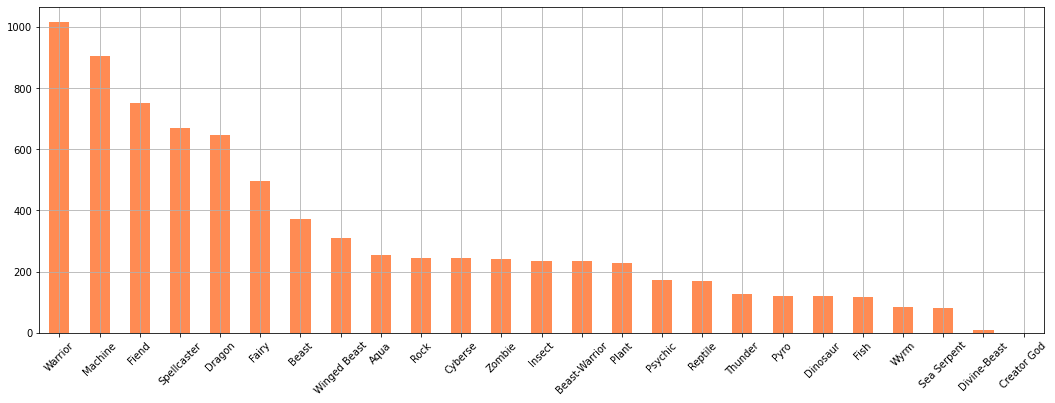

In [173]:
colors = card_colors['Monster Card']
formatted_monster_df['Monster type'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=45, color = colors)

##### Monster type vs. Attribute

In [508]:
pd.crosstab(formatted_full_df['Monster type'],formatted_full_df['Attribute'], dropna=False)

Attribute,DARK,DIVINE,EARTH,FIRE,LIGHT,WATER,WIND
Monster type,,,,,,,
Aqua,10,0,6,10,4,219,6
Beast,36,0,211,16,72,14,24
Beast-Warrior,36,0,81,53,33,16,15
Creator God,0,1,0,0,0,0,0
Cyberse,62,0,35,43,63,28,12
Dinosaur,11,0,58,32,5,8,6
Divine-Beast,0,8,0,0,0,0,0
Dragon,249,0,47,48,162,28,113
Fairy,53,0,57,15,320,25,25


<AxesSubplot:xlabel='Monster type', ylabel='Attribute'>

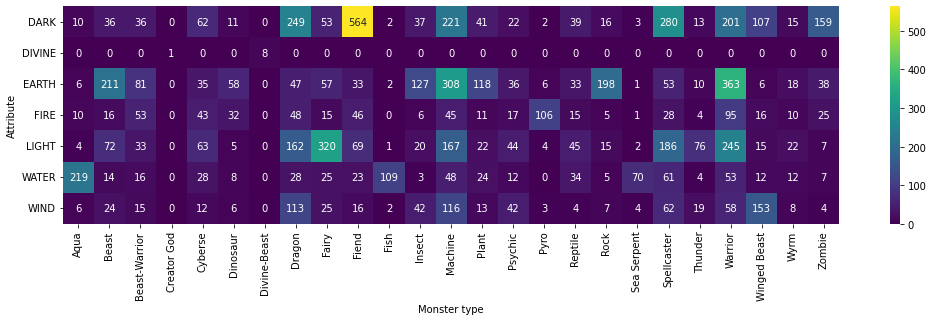

In [520]:
plt.figure(figsize = (18,4))
sns.heatmap(pd.crosstab(formatted_full_df['Attribute'],formatted_full_df['Monster type']), annot=True, fmt="g", cmap='viridis', square=True)

##### Monster type vs. primary type

In [524]:
pd.crosstab(formatted_full_df['Monster type'],formatted_full_df['Primary type'], dropna=False)

Primary type,Effect Monster,Fusion Monster,Link Monster,Monster Token,Normal Monster,Ritual Monster,Synchro Monster,Xyz Monster
Monster type,,,,,,,,
Aqua,154,11,3,0,59,8,3,17
Beast,268,16,9,0,54,1,14,11
Beast-Warrior,161,11,8,0,21,2,8,23
Creator God,1,0,0,0,0,0,0,0
Cyberse,122,4,92,0,6,6,5,8
Dinosaur,85,7,3,0,18,0,4,3
Divine-Beast,5,0,0,0,0,0,0,0
Dragon,341,62,33,0,45,15,93,58
Fairy,357,20,24,0,36,15,17,26


<AxesSubplot:xlabel='Monster type', ylabel='Primary type'>

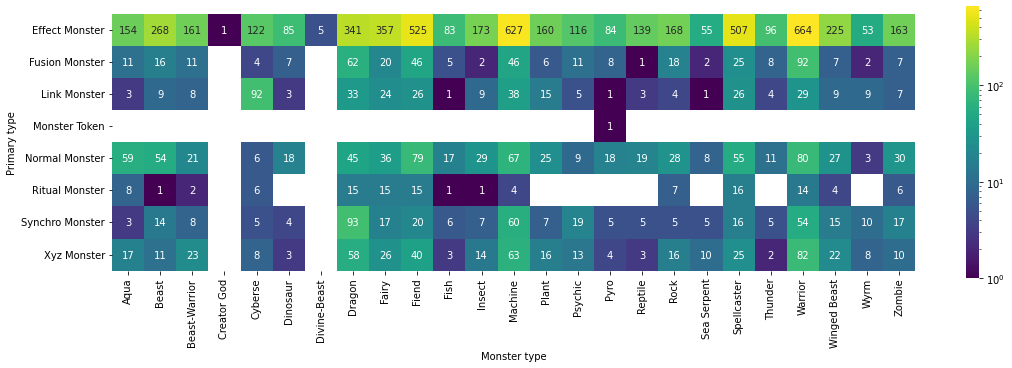

In [530]:
plt.figure(figsize = (18,5))
sns.heatmap(pd.crosstab(formatted_full_df['Primary type'],formatted_full_df['Monster type']), annot=True, fmt="g", cmap='viridis', square=True, norm = LogNorm())

##### Monster type vs. secondary type

In [532]:
pd.crosstab(formatted_full_df['Monster type'],formatted_full_df['Secondary type'], dropna=False)

Secondary type,Flip monster,Gemini monster,Spirit monster,Toon monster,Tuner monster,Union monster
Monster type,,,,,,
Aqua,4,4,1,1,10,3
Beast,15,1,2,0,22,0
Beast-Warrior,1,0,1,0,9,0
Cyberse,0,0,0,0,6,0
Dinosaur,0,0,0,0,7,0
Dragon,1,6,1,3,42,4
Fairy,6,2,7,0,20,5
Fiend,27,4,2,1,41,1
Fish,0,1,0,0,5,0


<AxesSubplot:xlabel='Monster type', ylabel='Secondary type'>

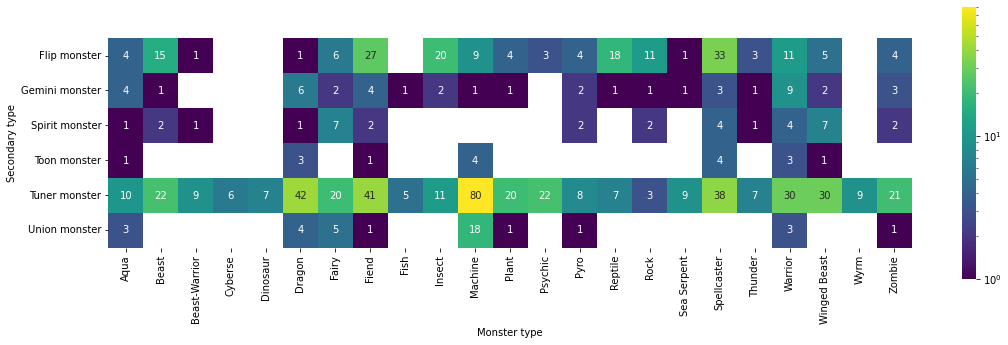

In [536]:
plt.figure(figsize = (18,5))
sns.heatmap(pd.crosstab(formatted_full_df['Secondary type'],formatted_full_df['Monster type']), annot=True, fmt="g", cmap='viridis', square=True, norm = LogNorm())

#### Effect type

In [285]:
formatted_monster_df[formatted_monster_df['Effect type'].notna()].drop(columns=['Card type']).explode('Effect type').groupby('Effect type').nunique()

,Name,Password,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,TCG status,OCG status,Modification date
Effect type,,,,,,,,,,,,,,,
Activation condition,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1
Condition,2932,2875,7,6,7,25,14,63,63,13,5,52,5,6,2911
Continuous Effect,2108,2091,6,5,7,24,14,59,52,12,6,48,4,4,2106
Continuous-like Effect,233,233,6,3,6,21,11,42,36,13,1,2,3,3,233
Flip effect,169,168,1,1,6,19,12,38,33,1,0,0,3,5,169
Ignition Effect,2537,2516,6,6,7,24,13,66,61,12,5,42,5,6,2521
Ignition-like Effect,214,205,6,2,6,20,12,35,32,13,1,1,3,5,211
Lingering effect,16,16,2,1,6,11,7,11,13,0,2,2,2,1,16
Maintenance cost,44,44,3,0,6,12,8,21,18,2,1,1,1,1,44


<AxesSubplot:>

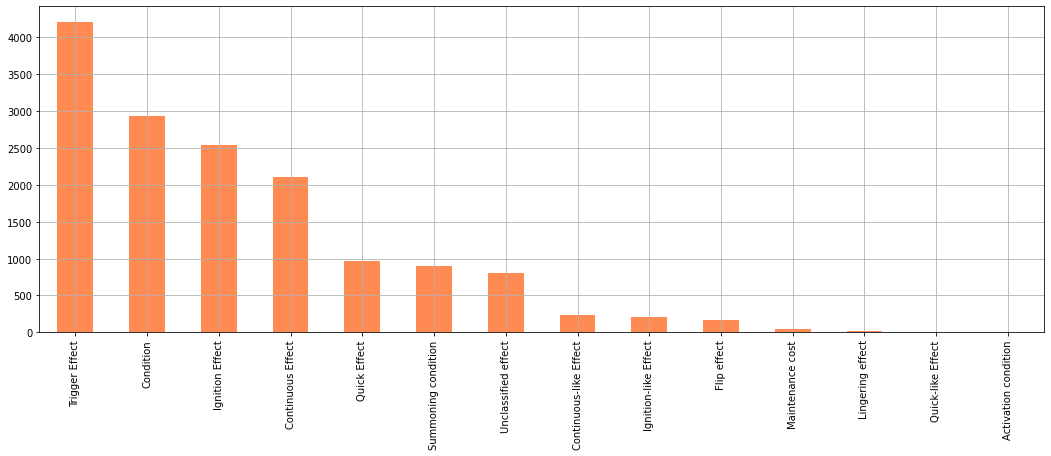

In [291]:
colors = card_colors['Effect Monster']
formatted_monster_df['Effect type'].explode('Effect type').value_counts().plot.bar(figsize = (18,6), grid = True, color = colors)

#### ATK

In [220]:
formatted_monster_df.drop(columns=['Card type']).groupby('ATK').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Primary type,Secondary type,Attribute,Monster type,Level/Rank,DEF,Pendulum Scale,Link,Link Arrows,Effect type,TCG status,OCG status,Modification date
ATK,,,,,,,,,,,,,,,
0,599,574,8,5,6,23,13,35,9,5,15,89,6,7,597
50,2,2,1,0,2,2,1,2,0,0,0,2,1,1,2
100,214,213,5,3,6,20,11,27,8,2,2,48,2,3,214
150,1,1,1,0,1,1,1,1,0,0,0,0,1,1,1
200,114,114,6,5,6,20,7,21,4,1,2,34,2,4,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600,2,2,1,0,2,1,1,1,0,0,0,2,1,1,2
5000,9,9,5,0,3,4,2,4,0,1,1,8,1,1,9
?,83,74,6,1,7,20,15,8,2,1,1,34,5,4,83


<AxesSubplot:>

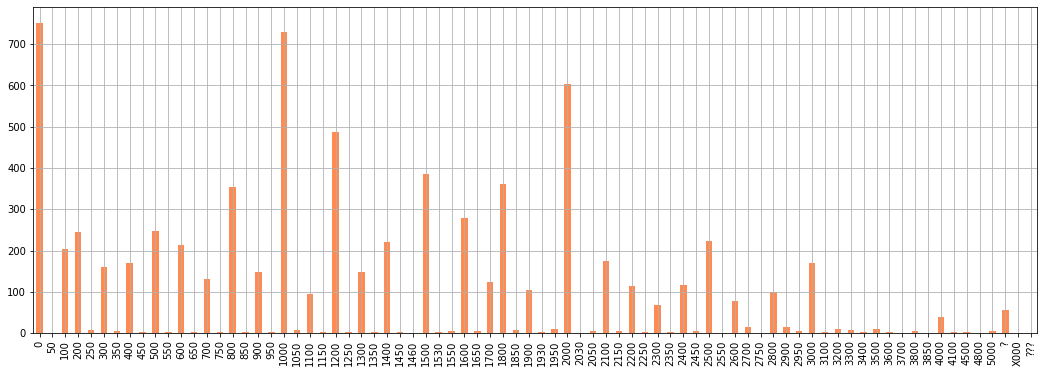

In [175]:
colors = card_colors['Monster Card']
formatted_monster_df['DEF'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, color = colors)

#### DEF

In [221]:
formatted_monster_df.drop(columns=['Card type']).groupby('DEF').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,Pendulum Scale,Link,Link Arrows,Effect type,TCG status,OCG status,Modification date
DEF,,,,,,,,,,,,,,,
0,752,722,7,6,6,23,14,45,10,0,0,101,5,6,748
50,1,1,1,0,1,1,1,1,0,0,0,1,1,1,1
100,204,203,5,4,6,19,10,24,8,0,0,45,3,3,203
200,245,244,5,5,6,23,10,31,5,0,0,47,3,3,245
250,8,8,2,1,4,5,2,4,0,0,0,5,1,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4800,1,1,1,0,1,1,1,1,0,0,0,1,1,1,1
5000,5,5,2,0,3,3,2,2,0,0,0,4,1,1,5
?,56,49,5,1,7,17,14,2,1,0,0,25,4,4,56


<AxesSubplot:>

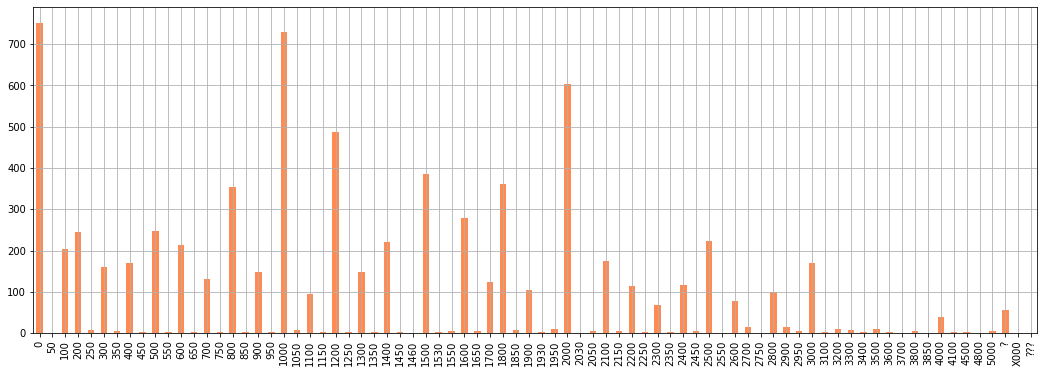

In [178]:
colors = card_colors['Monster Card']
formatted_monster_df['DEF'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, color = colors)

#### Level/Rank

In [223]:
formatted_monster_df.drop(columns=['Card type', 'Link', 'Link Arrows']).groupby('Level/Rank').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Primary type,Secondary type,Attribute,Monster type,ATK,DEF,Pendulum Scale,Effect type,TCG status,OCG status,Modification date
Level/Rank,,,,,,,,,,,,,
0,6,6,2,0,2,2,3,3,0,5,2,2,6
1,621,596,7,5,6,23,22,29,10,79,4,5,619
2,658,648,6,5,6,23,30,30,7,71,5,6,657
3,1135,1129,6,5,6,23,41,36,9,92,4,7,1135
4,2310,2298,6,6,6,23,54,47,9,134,5,7,2302
5,589,587,6,6,6,23,46,38,8,83,4,4,589
6,591,586,6,6,6,23,38,38,9,90,6,6,592
7,459,450,6,6,6,23,36,35,9,99,5,6,461
8,654,637,6,5,6,23,42,41,8,111,5,5,656


<AxesSubplot:>

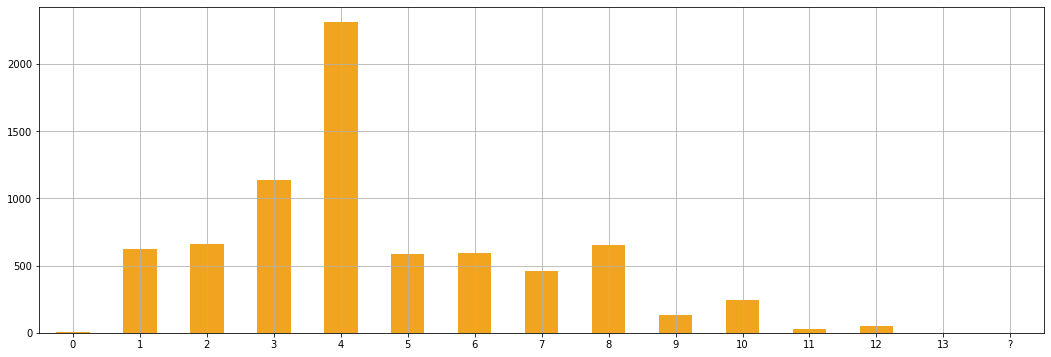

In [192]:
colors = card_colors['Level']
formatted_monster_df['Level/Rank'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, rot=0, color= colors)

#### Pendulum scale

In [224]:
formatted_monster_df.drop(columns=['Card type', 'Link', 'Link Arrows']).groupby('Pendulum Scale').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Effect type,TCG status,OCG status,Modification date
Pendulum Scale,,,,,,,,,,,,,
0,10,10,2,1,5,7,6,5,5,8,1,1,10
1,67,64,5,2,6,10,11,28,26,37,3,4,64
2,36,35,2,1,6,11,6,17,22,21,3,3,36
3,36,36,2,1,6,15,8,22,15,23,1,1,36
4,32,32,5,0,5,8,8,18,16,25,1,1,32
5,34,34,2,1,6,12,7,23,21,20,3,3,34
6,15,14,1,1,4,7,6,11,11,11,1,2,15
7,27,26,2,1,6,14,6,19,17,14,1,2,27
8,39,39,5,1,6,9,8,19,18,23,1,3,39


<AxesSubplot:>

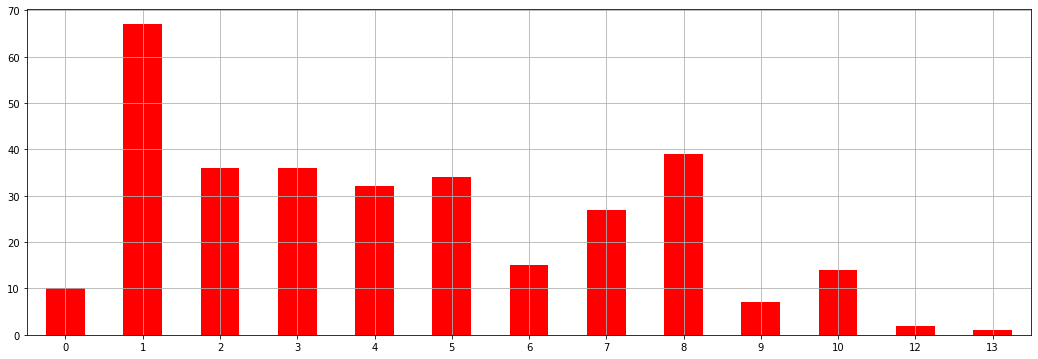

In [193]:
colors = card_colors['Pendulum Monster']
formatted_monster_df['Pendulum Scale'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, rot=0, color = colors)

#### Link

In [225]:
formatted_monster_df.drop(columns=['Card type', 'Primary type', 'Secondary type','Level/Rank','DEF','Pendulum Scale']).groupby('Link').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Attribute,Monster type,ATK,Link Arrows,Effect type,TCG status,OCG status,Modification date
Link,,,,,,,,,,
1,47,47,6,11,10,8,18,3,3,47
2,179,179,6,23,23,18,31,3,3,179
3,81,81,6,16,17,17,25,2,2,81
4,43,40,6,15,12,13,20,3,4,43
5,8,5,2,5,4,3,5,2,2,8
6,1,1,1,1,1,1,1,1,1,1


<AxesSubplot:>

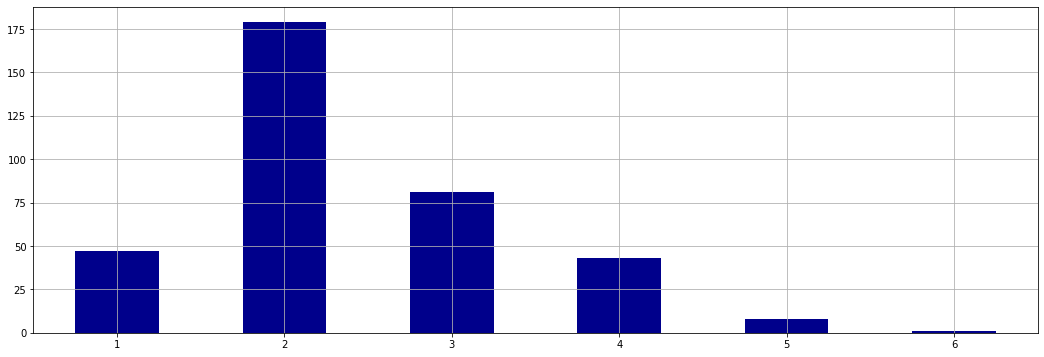

In [194]:
colors = card_colors['Link Monster']
formatted_monster_df['Link'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, rot=0, color = colors)

#### Link Arrows

##### By combination

In [226]:
formatted_monster_df.drop(columns=['Card type', 'Primary type', 'Level/Rank', 'Pendulum Scale', 'Link', 'Secondary type', 'DEF']).groupby('Link Arrows').nunique()

,Name,Password,Attribute,Monster type,ATK,Effect type,TCG status,OCG status,Modification date
Link Arrows,,,,,,,,,
"(←,)",5,5,2,3,2,4,3,2,5
"(←, ↑)",4,4,2,3,4,3,1,1,4
"(←, →)",18,18,6,8,11,8,2,2,18
"(←, →, ↑)",7,7,3,5,6,6,1,1,7
"(↑,)",10,10,5,5,6,9,1,1,10
"(↑, ↖, ↗)",2,2,2,2,2,1,1,1,2
"(→,)",2,2,2,2,1,2,1,1,2
"(→, ↑)",2,2,2,2,2,1,1,1,2
"(↓,)",18,18,5,7,9,10,2,3,18


<AxesSubplot:>

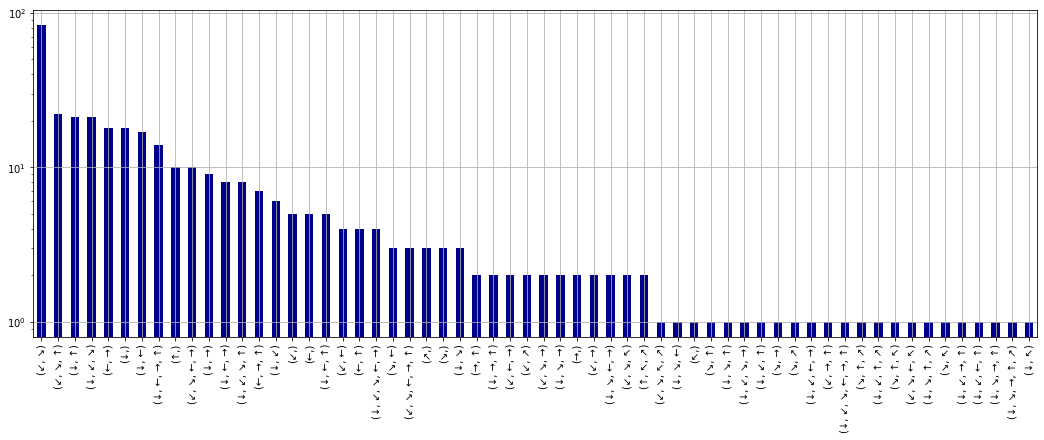

In [195]:
colors = card_colors['Link Monster']
formatted_monster_df['Link Arrows'].value_counts().plot.bar(figsize = (18,6), logy=True, grid = True, color = colors)

##### By unique

In [274]:
formatted_monster_df[formatted_monster_df['Link Arrows'].notna()].drop(columns=['Card type', 'Primary type', 'Level/Rank', 'Pendulum Scale', 'Link', 'Secondary type', 'DEF']).explode('Link Arrows').groupby('Link Arrows').nunique()

,Name,Password,Attribute,Monster type,ATK,Effect type,TCG status,OCG status,Modification date
Link Arrows,,,,,,,,,
←,111,105,6,20,29,33,4,3,111
↑,113,110,6,18,27,30,3,4,113
→,97,91,6,18,27,28,3,3,97
↓,153,147,6,19,31,40,3,4,153
↖,10,10,5,5,9,6,1,2,10
↗,13,13,5,6,9,6,1,2,13
↘,183,180,6,22,32,35,4,4,183
↙,186,183,6,22,33,37,4,4,186


<AxesSubplot:>

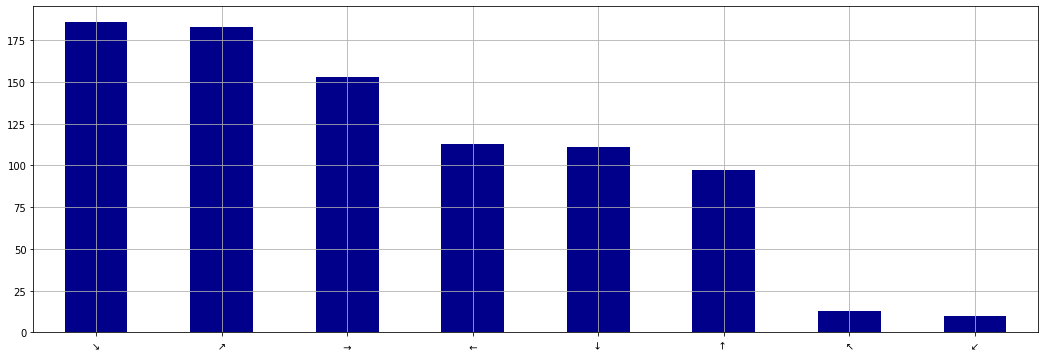

In [278]:
colors = card_colors['Link Monster']
formatted_monster_df['Link Arrows'].explode('Link Arrows').value_counts().plot.bar(figsize = (18,6), grid = True, color = colors)

### Spell & Trap

#### Properties

In [227]:
formatted_st_df.drop(columns=['Card type']).groupby('Property').nunique()

,Name,Password,Effect type,TCG status,OCG status,Modification date
Property,,,,,,
Continuous Spell Card,404,400,53,5,5,401
Continuous Trap Card,484,474,63,4,4,484
Counter Trap Card,153,149,17,2,3,153
Equip Spell Card,256,256,36,2,2,256
Field Spell Card,265,260,35,5,5,265
Normal Spell Card,902,897,43,4,6,902
Normal Trap Card,1139,1134,47,4,6,1130
Quick-Play Spell Card,410,402,32,3,5,407
Ritual Spell Card,72,72,8,1,1,72


<AxesSubplot:>

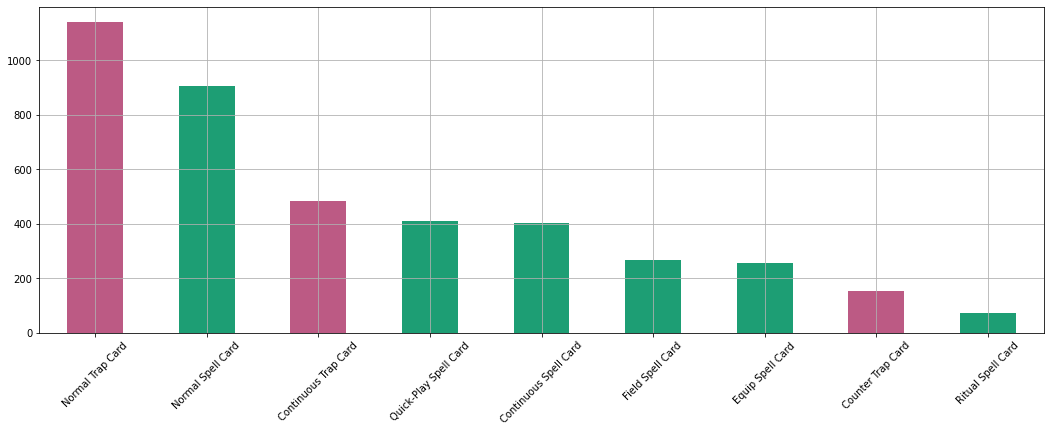

In [255]:
colors = [card_colors[i] for i in formatted_full_df[['Card type','Property']].value_counts().index.get_level_values(0)]
formatted_st_df['Property'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=45, color = colors)

#### Effect type

In [407]:
formatted_st_df.explode('Effect type').groupby('Effect type').nunique()

,Name,Password,Card type,Property,TCG status,OCG status,Modification date
Effect type,,,,,,,
Activation condition,827,820,2,8,4,5,825
Condition,1609,1580,2,9,5,5,1594
Continuous Effect,18,18,2,6,1,1,18
Continuous-like Effect,877,865,2,7,5,5,877
Cost,449,447,2,7,4,4,449
Effect,2858,2830,2,9,5,6,2833
Ignition Effect,1,1,1,1,1,1,1
Ignition-like Effect,415,408,1,6,4,5,411
Lingering effect,93,93,2,6,3,3,93


##### - Spell & Trap discrimination

In [408]:
spell = formatted_spell_df['Effect type'].explode('Effect type').value_counts().rename('Spell Card')
trap = formatted_trap_df['Effect type'].explode('Effect type').value_counts().rename('Trap Card')
diff = pd.concat([spell, trap], axis = 1)
diff

,Spell Card,Trap Card
Effect,1485.0,1374.0
Condition,1083.0,527.0
Continuous-like Effect,597.0,281.0
Trigger Effect,535.0,273.0
Ignition-like Effect,415.0,NaN
Activation condition,243.0,584.0
Cost,241.0,208.0
Unclassified effect,60.0,19.0
Lingering effect,56.0,37.0
Maintenance cost,11.0,11.0


<AxesSubplot:>

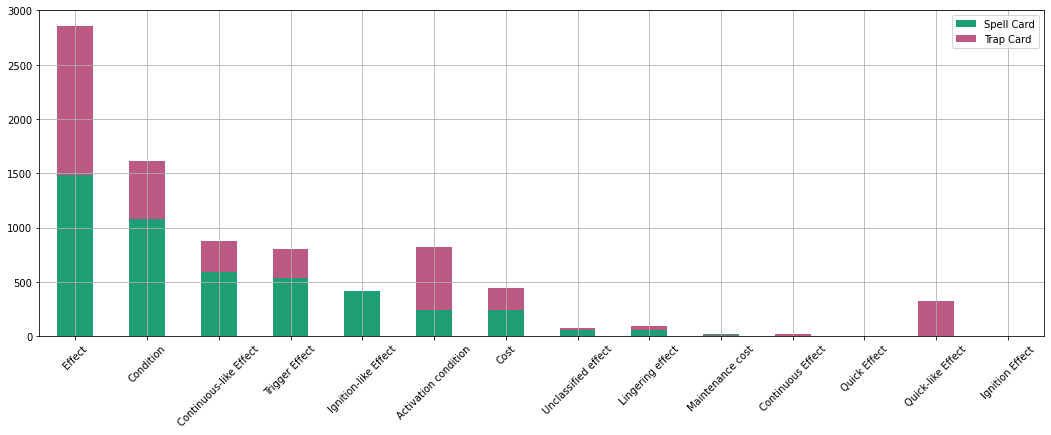

In [409]:
colors = {'Spell Card': card_colors['Spell Card'], 'Trap Card': card_colors['Trap Card']}
diff.plot.bar(figsize = (18,6), stacked = True, grid = True, rot=45, color = colors)

### TCG & OCG status

#### TGC status

In [35]:
formatted_full_df.groupby('TCG status', dropna=False).nunique()

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,OCG status,Modification date
TCG status,,,,,,,,,,,,,,,,,
Forbidden,99,99,3,7,6,2,6,19,12,27,21,2,4,10,46,4,99
Illegal,38,0,3,3,6,0,6,14,5,11,12,2,2,2,6,1,38
Legal,20,0,1,0,1,0,5,11,5,6,7,0,0,0,0,1,20
Limited,81,81,3,7,7,3,6,15,9,20,20,3,2,2,43,4,80
Not yet released,8,6,1,0,3,0,4,6,8,8,6,0,0,0,6,2,8
Semi-Limited,9,9,3,4,2,0,3,3,1,3,3,0,0,0,8,3,9
Unlimited,11165,11162,3,9,18,6,7,24,14,80,75,13,6,59,338,4,11034
NaN,514,419,3,9,12,2,7,23,12,53,37,6,5,8,88,4,503


<AxesSubplot:>

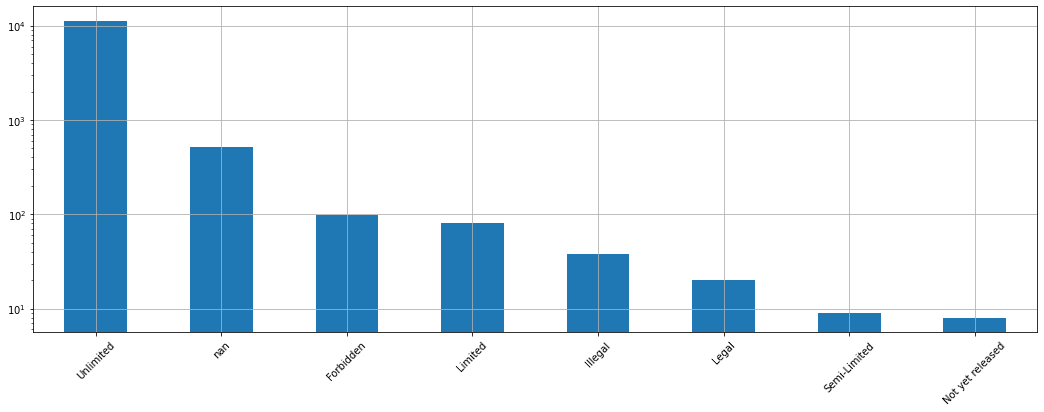

In [257]:
formatted_full_df['TCG status'].value_counts(dropna = False).plot.bar(figsize = (18,6), logy=True, grid = True, rot=45)

#### OCG status

In [37]:
formatted_full_df.groupby('OCG status', dropna=False).nunique()

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,TCG status,Modification date
OCG status,,,,,,,,,,,,,,,,,
Forbidden,87,87,3,7,6,4,6,19,11,28,21,3,4,7,38,3,87
Illegal,32,1,3,2,7,1,6,12,8,14,15,2,2,2,8,1,32
Legal,38,0,1,0,2,0,6,17,7,8,8,0,0,0,0,1,38
Limited,66,66,3,7,7,2,6,13,9,18,17,3,3,5,36,4,66
Not yet released,47,0,3,7,5,1,6,12,10,19,18,3,0,0,28,1,47
Semi-Limited,28,28,3,5,4,2,3,9,4,9,7,1,0,0,18,4,28
Unlimited,11569,11541,3,9,18,6,7,25,14,81,76,13,6,59,346,5,11427
NaN,63,50,3,8,8,1,6,17,10,23,22,1,3,4,27,3,63


<AxesSubplot:>

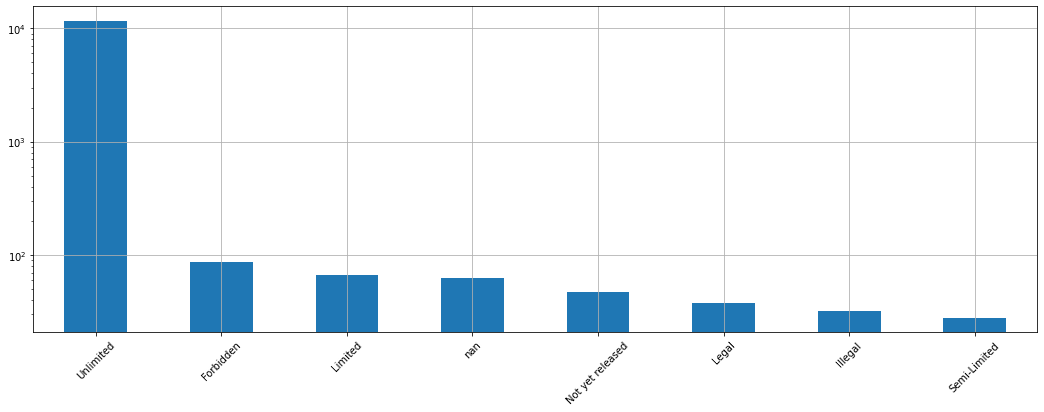

In [258]:
formatted_full_df['OCG status'].value_counts(dropna = False).plot.bar(figsize = (18,6), logy=True, grid = True, rot=45)

#### TCG vs. OCG status

In [259]:
pd.crosstab(formatted_full_df['OCG status'],formatted_full_df['TCG status'], dropna=False, margins = True)

TCG status,Forbidden,Illegal,Legal,Limited,Not yet released,Semi-Limited,Unlimited,All
OCG status,,,,,,,,
Forbidden,72,0,0,5,0,0,10,87
Illegal,0,26,0,0,0,0,0,32
Legal,0,0,20,0,0,0,0,38
Limited,6,0,0,35,0,3,22,66
Not yet released,0,0,0,0,1,0,0,47
Semi-Limited,3,0,0,5,0,3,17,28
Unlimited,18,0,0,36,6,3,11068,11575
All,99,38,20,81,8,9,11167,11936


<AxesSubplot:xlabel='TCG status', ylabel='OCG status'>

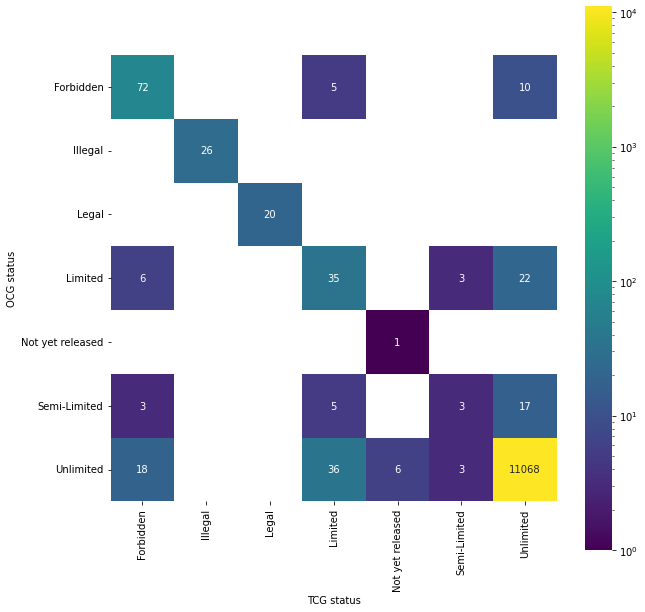

In [268]:
plt.figure(figsize = (10,10))
sns.heatmap(pd.crosstab(formatted_full_df['OCG status'],formatted_full_df['TCG status'], dropna=False), annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())

## Searches

In [41]:
formatted_full_df.loc[formatted_full_df['OCG status'] == 'Not yet released'].loc[formatted_full_df['TCG status'] == 'Not yet released']

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,TCG status,OCG status,Modification date
5240,Rainbow Dragon Overdrive,NaN,Monster Card,NaN,"(Effect Monster, Fusion Monster)",NaN,LIGHT,Dragon,12,4000,0,NaN,NaN,NaN,"(Continuous Effect, Quick Effect, Summoning co...",Not yet released,Not yet released,Thu Jun 16 13:55:27 2022


In [42]:
formatted_full_df.loc[formatted_full_df['Level/Rank']=='?']

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,TCG status,OCG status,Modification date
6236,Dark Soul Token,NaN,Monster Card,NaN,"(Monster Token, Normal Monster)",NaN,DARK,Zombie,?,?,0,NaN,NaN,NaN,NaN,NaN,Legal,Sun Jan 16 16:02:19 2022


In [43]:
formatted_full_df.loc[formatted_full_df['Primary type']=='Monster Token']

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,TCG status,OCG status,Modification date


In [44]:
formatted_full_df.loc[formatted_full_df['Name'].str.contains('Token')]

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,TCG status,OCG status,Modification date
2049,Token Sundae,52971673,Spell Card,Normal Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Effect,)",Unlimited,Unlimited,Wed Apr 20 15:58:58 2022
2050,Token Thanksgiving,57182235,Spell Card,Normal Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Effect,)",Unlimited,Unlimited,Fri Feb 12 19:14:18 2021
3398,Oh Tokenbaum!,97173708,Trap Card,Normal Trap Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Cost, Effect)",Unlimited,Unlimited,Wed Apr 20 14:37:58 2022
3883,Token Feastevil,83675475,Trap Card,Normal Trap Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Activation condition, Effect)",Unlimited,Unlimited,Wed Apr 20 15:56:51 2022
3884,Token Stampede,14342283,Trap Card,Continuous Trap Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Continuous-like Effect,)",Unlimited,Unlimited,Fri Oct 1 12:42:13 2021
4485,Dragon Lord Token,NaN,Monster Card,NaN,"(Monster Token, Normal Monster)",NaN,LIGHT,Dragon,1,0,0,NaN,NaN,NaN,NaN,Legal,Legal,Sat Mar 14 16:45:00 2020
4504,Dual Avatar Spirit Token,NaN,Monster Card,NaN,"(Monster Token, Normal Monster)",NaN,LIGHT,Warrior,2,0,0,NaN,NaN,NaN,NaN,Legal,Legal,Thu Jun 10 15:53:13 2021
4553,Emissary of Darkness Token,NaN,Monster Card,NaN,"(Monster Token, Normal Monster)",NaN,LIGHT,Fairy,7,?,?,NaN,NaN,NaN,NaN,NaN,Legal,Wed Apr 20 11:27:34 2022
4634,Gadget Token,NaN,Monster Card,NaN,"(Monster Token, Normal Monster)",NaN,LIGHT,Cyberse,2,0,0,NaN,NaN,NaN,NaN,NaN,Legal,Tue Dec 28 02:59:44 2021
4661,Generaider Token,NaN,Monster Card,NaN,"(Monster Token, Normal Monster)",NaN,LIGHT,Fairy,4,1500,1500,NaN,NaN,NaN,NaN,Legal,Legal,Mon May 30 10:02:36 2022
